<a href="https://colab.research.google.com/github/PaleoLipidRR/BAYSPAR/blob/master/BAYSPAR/BAYSPAR_recode_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %pip uninstall matplotlib
# %pip install matplotlib==3.5.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached matplotlib-3.5.3-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)


In [ ]:
# %pip install proplot
# %pip install cartopy
# %pip install pyrolite

In [ ]:
import pandas as pd
import numpy as np
import xarray as xr
import seaborn as sns

import scipy as scipy
import scipy.io as sciio
from scipy import stats
from sklearn import linear_model, datasets
from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor, TheilSenRegressor
from sklearn import mixture
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib as mpl
import numpy.matlib 
import matplotlib.pyplot as plt

import proplot as plot
import cartopy.crs as ccrs

from pyrolite.util.time import Timescale
gts = Timescale()

import string
import os
import requests
import io
import netCDF4
from netCDF4 import Dataset

/usr/local/lib/python3.7/dist-packages/proplot/__init__.py:71: ProplotWarning: Rebuilding font cache. This usually happens after installing or updating proplot.
  register_fonts(default=True)


In [ ]:
def EarthChordDistances_2(llPoints1, llPoints2):
    # function Chord_Dists=EarthChordDistances_2(llPoints1, llPoints2)
    # Each input is N/M by 2, each row a (long, lat) pair, -180<long<180; -90<lat<90.
    # Output is a N by M matrix of chordal distances in KM (approximating the
    # earth as a sphere), where the (i,j) entry is the distance between the ith
    # row of llPoints and the jth row of llPoints2.
    # radius of the earth is taken as 6378.137


    RR=6378.137 #radius of the earth in km
    
    llPoints1 = np.atleast_2d(llPoints1)
    llPoints2 = np.atleast_2d(llPoints2)
    N=len(llPoints1[:,0])
    M=len(llPoints2[:,0])

    # make a N*M by 4 matrix. Each row one of the N*M possible sets of
    # two points:

    Pts_paired_Vec=np.concatenate([np.kron(llPoints1, np.ones((M,1))),np.kron(np.ones((N,1)), llPoints2)],axis=1)
    
    Half_Angles_AsVec=np.arcsin(
        np.sqrt(
            np.sin((Pts_paired_Vec[:,1]-Pts_paired_Vec[:,3])*np.pi/180/2)**2
            +np.cos(Pts_paired_Vec[:,1]*np.pi/180)*np.cos(Pts_paired_Vec[:,3]*np.pi/180)
            *np.sin(abs(Pts_paired_Vec[:,0]-Pts_paired_Vec[:,2])*np.pi/180/2)**2)
    )

    Chords_as_vec=2*RR*np.sin(Half_Angles_AsVec);
    Chord_Dists_Mat=np.reshape(Chords_as_vec, (M, N))
    return Chord_Dists_Mat
    

In [ ]:
def barspar_tex(dats, age, lon, lat, prior_std, runname):
    #load data files needed in the analysis
    folderpath= os.getcwd()+"/drive/MyDrive/Github/BAYSPAR/ModelOutput/"
    filepath = folderpath+f"Output_SpatAg_{runname}/params_standard.mat"
    params_standard = sciio.loadmat(filepath)
    alpha_samples_comp = params_standard['alpha_samples_comp']
    beta_samples_comp = params_standard['beta_samples_comp']
    tau2_samples = params_standard['tau2_samples']
    Locs_Comp = params_standard['Locs_Comp']
    
    #load obs SST data and locs
    filepath = folderpath+f"obs{runname}.mat"
    obs_data = sciio.loadmat(filepath)
    locs_st_obs = obs_data['locs_st_obs']
    st_obs_ave_vec = obs_data['st_obs_ave_vec']



    #grid spacing is hard-coded here:
    grid_half_space=10
    
    #ensemble is hard-coded here (will ask Jess):
    ens_sel=0

    #mininum number of grid cells used to calculate modern prior SST
    min_num=1

    #maximum distance to search over for modern prior SST
    max_dist=500

    # make sure input is column
    dats_col_vec=dats.reshape(len(dats[0]),1)

    Nsamps = 1000
    #thin the samples to the right number (so as to use the full span of the ensemble even if few samples are used.)
    ind_s= np.arange(0, len(tau2_samples[0]),int(len(tau2_samples[0])/Nsamps)) ### different from Tierney et al. (2014) MATLAB code
    alpha_samples_comp_thinned=alpha_samples_comp[:,ind_s]
    beta_samples_comp_thinned=beta_samples_comp[:,ind_s]
    tau2_samples_thinned=tau2_samples[:,ind_s]

    #get the number of obs
    Nd=len(dats_col_vec)
    arr1 = np.empty((Nd,3))
    arr1[:] = np.nan
    Preds=arr1 ### Output_Struct.Preds in the original BAYSPAR MATLAB
    SiteLoc=[lon,lat]

    arr2 = np.empty((2,1))
    arr2[:] = np.nan
    GridLoc=arr2 ### Output_Struct.GridLoc in the original BAYSPAR MATLAB
    PriorMean=np.array([[np.nan]]) ### Output_Struct.PriorMean in the original BAYSPAR MATLAB
    PriorStd=prior_std ### Output_Struct.PriorStd in the original BAYSPAR MATLAB

    if ens_sel==1:
        PredsEns=NaN(Nd, Nsamps) ### Output_Struct.PriorMean in the original BAYSPAR MATLAB

    # get the prior mean: constant across the calibration cases, as we just
    # average min_num sst obs, on the original 1 degree scale, that are closest to the
    # timeseries, or all that are within a max_dist search radius.

    # get the distance to each of the sst gridcells, on the original resolution:
    dists_prior=EarthChordDistances_2([lon, lat], locs_st_obs)

    # order by distance:
    vals_dist_prior, inds_dist_prior = np.sort(dists_prior,axis=0), np.argsort(dists_prior,axis=0)

    # get the number that are below the distance cutoff:
    max_dist=500
    num_below_dist=len(np.where(vals_dist_prior<max_dist)[0])
    num_below_dist

    # if this is larger than the min number, use it to select them:
    if num_below_dist>min_num:
        prior_mean=np.mean(st_obs_ave_vec[inds_dist_prior[:num_below_dist]])
    # otherwise use the smalles min_num:
    else:
        prior_mean=np.mean(st_obs_ave_vec[inds_dist_prior[:min_num]])

    # fill in the prior mean value in the output:    
    PriorMean=prior_mean ### Output_Struct.PriorMean in the original BAYSPAR MATLAB


    # figure out the alpha and beta series to draw from.
    # just find the index of the Locs_Comp entry that contains the inputted location:
    inder_g=np.where((abs(Locs_Comp[:,0]-lon)<=grid_half_space)&(abs(Locs_Comp[:,1]-lat)<=grid_half_space))[0]

    alpha_samples_comp_sampled=alpha_samples_comp_thinned[inder_g, :]
    beta_samples_comp_sampled=beta_samples_comp_thinned[inder_g, :]
    GridLoc=Locs_Comp[inder_g, :]

    ## Solve

    # Prior mean and inverse covariance matrix
    pmu = numpy.matlib.repmat(np.ones((Nd, 1))*prior_mean,1,Nsamps)
    pinv_cov = 1/(numpy.matlib.repmat(prior_std,Nd,Nsamps)**2)
    sigmaS = np.sqrt(tau2_samples_thinned);


    # # # Posterior calculations
    A = pinv_cov
    B = pmu
    C = (1/(numpy.matlib.repmat(sigmaS,Nd,1)**2))
    D = numpy.matlib.repmat(beta_samples_comp_sampled,Nd,1)
    E = np.subtract(dats_col_vec,numpy.matlib.repmat(alpha_samples_comp_sampled,Nd,1))

    post_mean_num = A * B + C * D * E
    post_mean_den = A + D**2 * C
    post_mean = post_mean_num / post_mean_den
    post_sig = np.sqrt(1/post_mean_den)
    Preds = numpy.random.normal(post_mean,post_sig)

    predicted_tex_dict = {
        "lon":lon,
        "lat":lat,
        "sampleAge":np.squeeze(age),
        "priorMean":PriorMean,
        "priorStd":PriorStd,
        "postTEX_SST":Preds,
        "postTEX_SST_median":np.median(Preds,axis=1),
        "postTEX_SST_std":np.std(Preds,axis=1)
    }
    return predicted_tex_dict

In [ ]:
# load test data
filepath = os.getcwd()+"/drive/MyDrive/Github/BAYSPAR/ModelOutput/tex_testdata.mat"
tex_testdata = sciio.loadmat(filepath)
shevenell2011_texdata = tex_testdata['shevenell2011']
lat = shevenell2011_texdata['lat']
lon = shevenell2011_texdata['lon']
dats = shevenell2011_texdata['tex86']
age = shevenell2011_texdata['age']
prior_std=6
runname='subT'

lat = lat[0][0][0][0]
lon = lon[0][0][0][0]
dats = (dats[0][0]).reshape(1,(len(dats[0][0])))  
age = (age[0][0]).reshape(1,(len(age[0][0]))) 
runname = 'subT'

shevenell2011_BAYSPAR = barspar_tex(dats, age, lon, lat, prior_std, runname)
shevenell2011_BAYSPAR

{'lon': -64.20799166666667,
 'lat': -64.8527,
 'sampleAge': array([   80,   134,   189,   243,   350,   403,   456,   508,   612,
          664,   715,   811,   867,   917,   966,  1016,  1113,  1162,
         1210,  1258,  1352,  1399,  1446,  1534,  1584,  1630,  1675,
         1810,  1854,  1898,  1942,  2028,  2114,  2156,  2220,  2303,
         2426,  2508,  2588,  2628,  2757,  3199,  3272,  3380,  3452,
         3522,  3592,  3815,  3915,  4015,  4113,  4194,  4258,  4322,
         4386,  4449,  4449,  4511,  4558,  4635,  4758,  4940,  5000,
         5060,  5060,  5134,  5223,  5312,  5488,  5561,  5649,  5678,
         5766,  5912,  5985,  6431,  6461,  6932,  7230,  7424,  7457,
         7740,  7808,  8087,  8141,  8304,  8433,  8527,  8641,  8698,
         8835,  9014,  9137,  9259,  9333,  9407,  9439,  9488,  9488,
         9538,  9652,  9685,  9718,  9767, 10213, 10297, 10352, 10464,
        10511, 10548, 10689, 10764, 10801, 10950, 11034, 11173, 11303,
        11359, 113

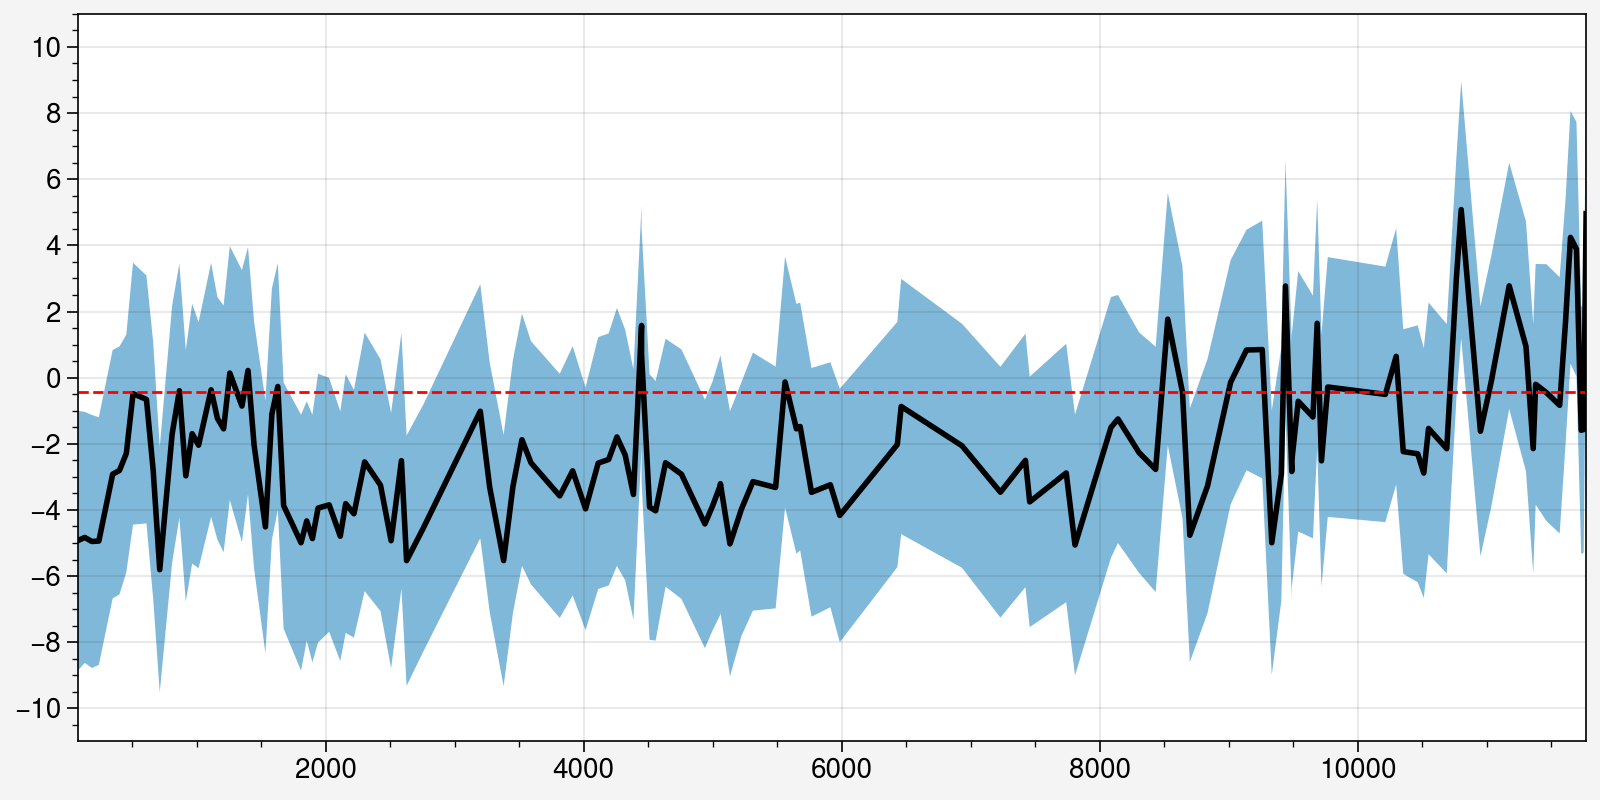

In [ ]:
fig, axs = plot.subplots(figsize=(8,4))

ax = axs[0]

plot_data = shevenell2011_BAYSPAR
ax.plot(plot_data['sampleAge'],plot_data['postTEX_SST_median'],lw=2,c='k')
ax.fill_between(plot_data['sampleAge'],
                plot_data['postTEX_SST_median']-plot_data['postTEX_SST_std'],
                plot_data['postTEX_SST_median']+plot_data['postTEX_SST_std'],
                alpha=0.5)
ax.hlines(plot_data['priorMean'],plot_data['sampleAge'].min(),plot_data['sampleAge'].max(),c='r',ls='--')
ax.format(
    ylim=(-11,11),
    yticks=np.arange(-10,11,2)
)

In [ ]:
# load test data
filepath = os.getcwd()+"\\ModelOutput\\tex_testdata.mat"
tex_testdata = sciio.loadmat(filepath)
shevenell2011_texdata = tex_testdata['shevenell2011']
lat = shevenell2011_texdata['lat']
lon = shevenell2011_texdata['lon']
dats = shevenell2011_texdata['tex86']
age = shevenell2011_texdata['age']

# prepdata into the correct python format
prior_std = 6
ens_sel = 0 #default
ens_sel=ens_sel
lat = lat[0][0][0][0]
lon = lon[0][0][0][0]
dats_row_array = (dats[0][0]).reshape(1,(len(dats[0][0])))  
age_row_array = (age[0][0]).reshape(1,(len(age[0][0]))) 
runname = 'subT'


#load data files needed in the analysis
filepath = os.getcwd()+f"\\ModelOutput\\Output_SpatAg_{runname}\\params_standard.mat"
params_standard = sciio.loadmat(filepath)
alpha_samples_comp = params_standard['alpha_samples_comp']
beta_samples_comp = params_standard['beta_samples_comp']
tau2_samples = params_standard['tau2_samples']
Locs_Comp = params_standard['Locs_Comp']

#load obs SST data and locs
filepath = os.getcwd()+f"\\ModelOutput\\obs{runname}.mat"
obs_data = sciio.loadmat(filepath)
locs_st_obs = obs_data['locs_st_obs']
st_obs_ave_vec = obs_data['st_obs_ave_vec']



#grid spacing is hard-coded here:
grid_half_space=10

#mininum number of grid cells used to calculate modern prior SST
min_num=1

#maximum distance to search over for modern prior SST
max_dist=500
    
# make sure input is column
dats_col_vec=dats_row_array.reshape((len(dats[0][0]),1))  

Nsamps = 1000
#thin the samples to the right number (so as to use the full span of the ensemble even if few samples are used.)
ind_s= np.arange(0, len(tau2_samples[0]),int(len(tau2_samples[0])/Nsamps)) ### different from Tierney et al. (2014) MATLAB code
alpha_samples_comp_thinned=alpha_samples_comp[:,ind_s]
beta_samples_comp_thinned=beta_samples_comp[:,ind_s]
tau2_samples_thinned=tau2_samples[:,ind_s]

#get the number of obs
Nd=len(dats_col_vec)
arr1 = np.empty((Nd,3))
arr1[:] = np.nan
Preds=arr1 ### Output_Struct.Preds in the original BAYSPAR MATLAB
SiteLoc=[lon,lat]

arr2 = np.empty((2,1))
arr2[:] = np.nan
GridLoc=arr2 ### Output_Struct.GridLoc in the original BAYSPAR MATLAB
PriorMean=np.array([[np.nan]]) ### Output_Struct.PriorMean in the original BAYSPAR MATLAB
PriorStd=prior_std ### Output_Struct.PriorStd in the original BAYSPAR MATLAB

if ens_sel==1:
    PredsEns=NaN(Nd, Nsamps) ### Output_Struct.PriorMean in the original BAYSPAR MATLAB
    
# get the prior mean: constant across the calibration cases, as we just
# average min_num sst obs, on the original 1 degree scale, that are closest to the
# timeseries, or all that are within a max_dist search radius.

# get the distance to each of the sst gridcells, on the original resolution:
dists_prior=EarthChordDistances_2([lon, lat], locs_st_obs)

# order by distance:
vals_dist_prior, inds_dist_prior = np.sort(dists_prior,axis=0), np.argsort(dists_prior,axis=0)

# get the number that are below the distance cutoff:
max_dist=1500
num_below_dist=len(np.where(vals_dist_prior<max_dist)[0])
num_below_dist

# if this is larger than the min number, use it to select them:
if num_below_dist>min_num:
    prior_mean=np.mean(st_obs_ave_vec[inds_dist_prior[:num_below_dist]])
# otherwise use the smalles min_num:
else:
    prior_mean=np.mean(st_obs_ave_vec[inds_dist_prior[:min_num]])

# fill in the prior mean value in the output:    
PriorMean=prior_mean ### Output_Struct.PriorMean in the original BAYSPAR MATLAB


# figure out the alpha and beta series to draw from.
# just find the index of the Locs_Comp entry that contains the inputted location:
inder_g=np.where((abs(Locs_Comp[:,0]-lon)<=grid_half_space)&(abs(Locs_Comp[:,1]-lat)<=grid_half_space))[0]

alpha_samples_comp_sampled=alpha_samples_comp_thinned[inder_g, :]
beta_samples_comp_sampled=beta_samples_comp_thinned[inder_g, :]
GridLoc=Locs_Comp[inder_g, :]

## Solve

# Prior mean and inverse covariance matrix
pmu = numpy.matlib.repmat(np.ones((Nd, 1))*prior_mean,1,Nsamps)
pinv_cov = 1/(numpy.matlib.repmat(prior_std,Nd,Nsamps)**2)
sigmaS = np.sqrt(tau2_samples_thinned);


# # # Posterior calculations
A = pinv_cov
B = pmu
C = (1/(numpy.matlib.repmat(sigmaS,Nd,1)**2))
D = numpy.matlib.repmat(beta_samples_comp_sampled,Nd,1)
E = np.subtract(dats_col_vec,numpy.matlib.repmat(alpha_samples_comp_sampled,Nd,1))

post_mean_num = A * B + C * D * E
post_mean_den = A + D**2 * C
post_mean = post_mean_num / post_mean_den
post_sig = np.sqrt(1/post_mean_den)
Preds = numpy.random.normal(post_mean,post_sig)

predicted_tex_dict = {
    "lon":lon,
    "lat":lat,
    "sampleAge":age_row_array[0],
    "priorMean":PriorMean,
    "priorStd":PriorStd,
    "postTEX":Preds,
    "postTEX_median":np.median(Preds,axis=1),
    "postTEX_std":np.std(Preds,axis=1)
}

In [ ]:
predicted_tex = xr.Dataset(
    data_vars = dict(
        postMedian = (["x","y","sampleAge"],np.median(Preds,axis=1))
    ),
    coords=dict(
        lon=(["x"], lon),
        lat=(["y"], lat),
        sampleAge=age_row_array[0]
    )
)
predicted_tex 

ValueError: Could not convert tuple of form (dims, data[, attrs, encoding]): (['x'], -64.20799166666667) to Variable.

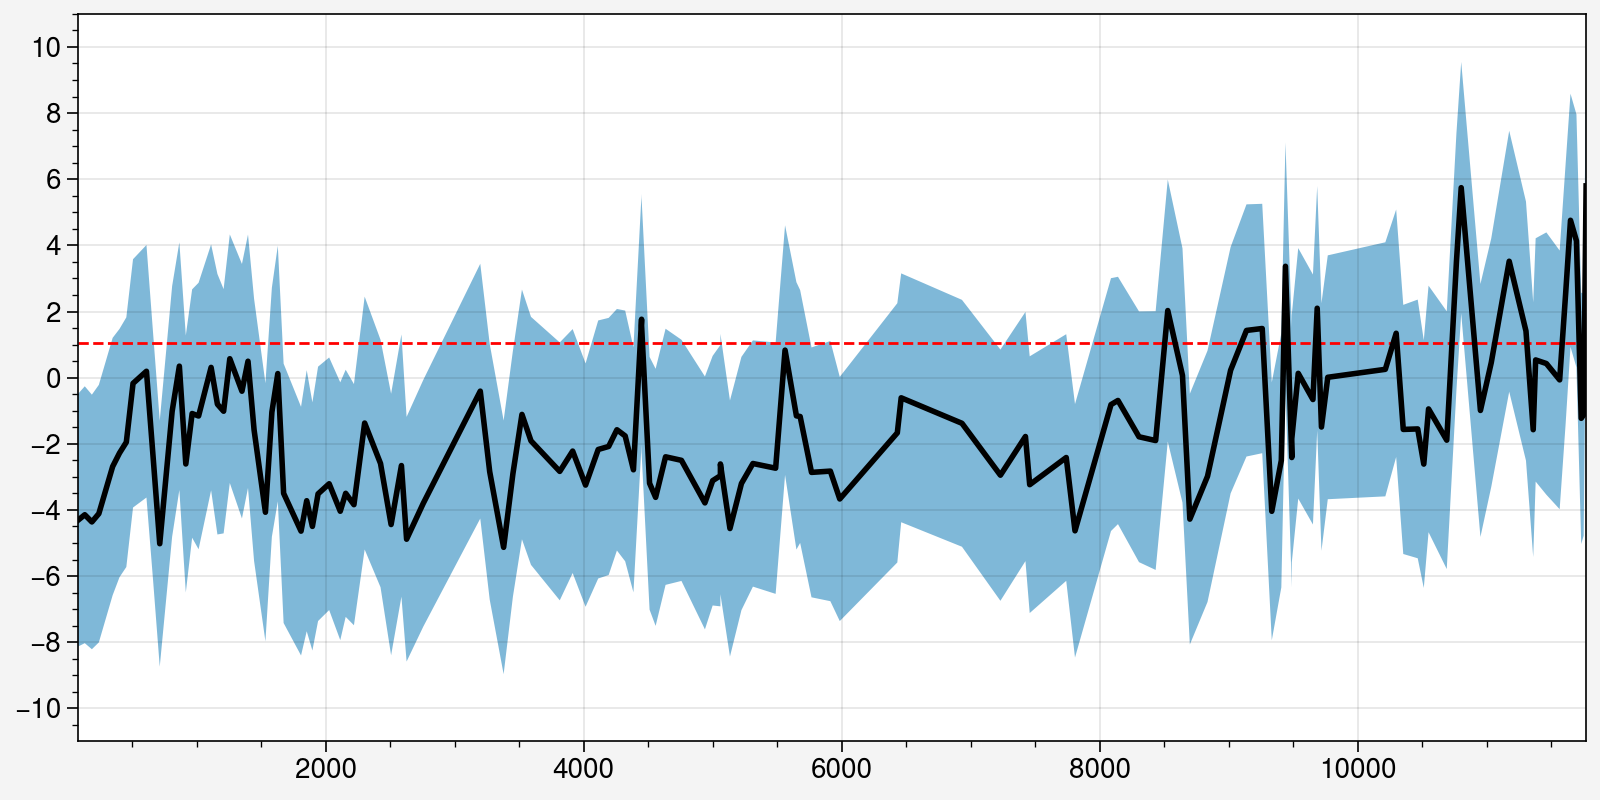

In [ ]:
fig, axs = plot.subplots(figsize=(8,4))

ax = axs[0]
dats_median = np.median(Preds,axis=1)
dats_std = np.std(Preds,axis=1)
ax.plot(age_row_array[0],dats_median,lw=2,c='k')
ax.fill_between(age_row_array[0],dats_median-dats_std,dats_median+dats_std,alpha=0.5)
ax.hlines(PriorMean,age_row_array[0][0],age_row_array[0][-1],c='r',ls='--')
ax.format(
    ylim=(-11,11),
    yticks=np.arange(-10,11,2)
)

(127, 1000)


(array([ 12.,  45., 103., 179., 256., 209., 112.,  62.,  16.,   6.]),
 array([-15.16525569, -12.85005414, -10.53485259,  -8.21965104,
         -5.90444949,  -3.58924794,  -1.27404639,   1.04115516,
          3.35635671,   5.67155826,   7.98675981]),
 <BarContainer object of 10 artists>)

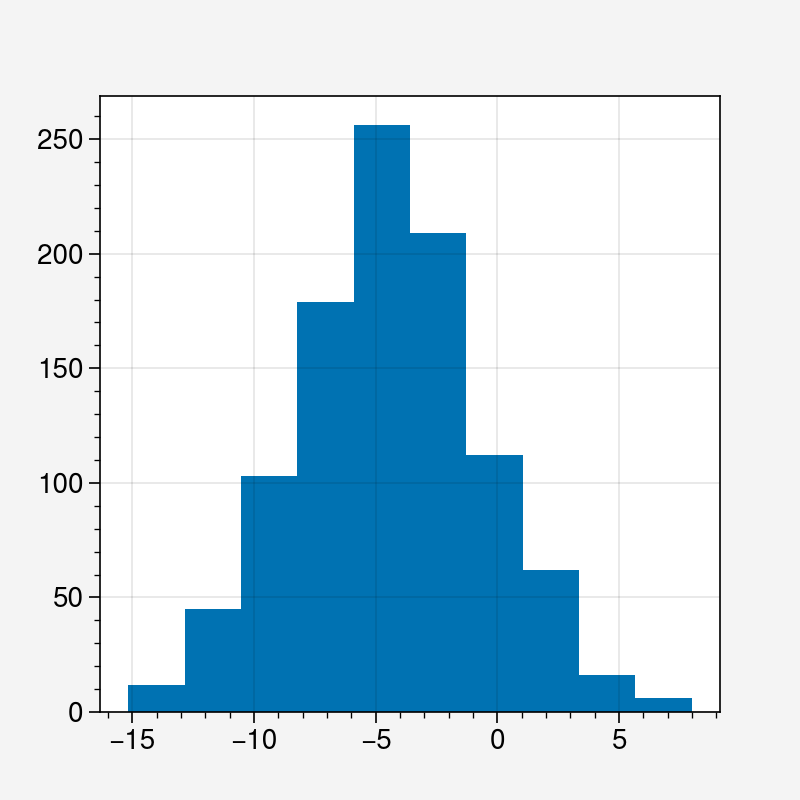

In [ ]:
print(np.shape(Preds))
plt.hist(Preds[0,:])


In [ ]:
test = np.concatenate([np.kron([[10,10]], np.ones((37105,1))),np.kron(np.ones((1,1)), locs_st_obs)],axis=1)

test[:,3]

In [ ]:
Pts_paired_Vec=[np.kron([10,10], np.ones((1,1))), np.kron(np.ones((1,1)), [0,0])]
Pts_paired_Vec[3]

In [ ]:
np.dot(np.reshape(np.ones([10,1]),(1,10)),10)

In [ ]:
def GMM_cluster(modeled_data,predicted_data,input_feature1,input_feature2,n_clusters):
    features=[input_feature1,input_feature2]
    
    X = modeled_data[features]
    Y = predicted_data[features]
    clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full',
                                            n_init=100,random_state=0).fit(X)
    return clusterer.predict(Y)

def calc_OD_PTD(selected_data):
    coef_PTD = -0.17223044944103333
    intercept_PTD = 0.8883866162103311
    # Function to find distance 
    a = float(coef_PTD)
    b = -1
    c = float(intercept_PTD)
    return abs(a*selected_data.gdgt23ratio+(b*selected_data.TEX86)+c)/np.sqrt(a*a+b*b)

In [ ]:
pd.set_option('display.max_rows',4,'display.max_columns',10)
# filepath = "/content/drive/MyDrive/Colab Notebooks/Excel/MarineAOA_project/"  ### Replace with your the location of your file --- for mounted Google Drive
filepath = "C:/Users/ratta/working-repo/spreadsheets/"  ### for local Git repository
filename = "PNAS_datasetS2_BeyondTEX86_RR_QC_09232022.xlsx"
df = pd.read_excel(filepath+filename,sheet_name='Sheet1')
df = df.iloc[:,1:]  ##This line is to remove the Unnamed: 0 column (the additional column after completing the pythonCodeS1 pre-processing)

df['publishedYear'] = df.Source2.apply(lambda st: st[st.find("(")+1:st.find(")")]).astype(int)

df.columns

In [ ]:
df2=df[df.lipidClass!='IPL-GDGTs'][((df.dataType_level1!='Culture - Hot spring')&
                                   (df.dataType_level1!='Hot spring')&
                                   (df.dataType_level1!='Culture - ThAOA')
                                           )]

In [ ]:
plt.hist(df2.methaneIndex)

In [ ]:
test_data = df[df.geoEpoch=='04_Miocene']
test_data

In [ ]:
pd.set_option('display.max_rows',None)
test_data.pivot_table(index='Site',values='TEX86',aggfunc='count')

In [ ]:
pd.set_option('display.max_rows',10)
site608 = test_data[test_data.Site==1318]
site608

In [ ]:
### Try to predict SST from TEX86
pd.set_option('display.max_rows',10)

ageMa_608 = np.array(site608.sampleAge)[:,np.newaxis]
TEX86_608 = np.atleast_2d(np.array(site608.TEX86))

Nobs_608 = TEX86_608.shape[1]
Nobs_608

In [ ]:
df_coretop = df2[df2.dataType_level1=='Core top']
df_SPM = df2[df2.dataType_level1=='Water-column SPM']

In [ ]:
df_coretop['cluster_label'] = GMM_cluster(df_SPM,df_coretop,'gdgt23ratio','TEX86',2)

df_coretop['OD_PTD'] = calc_OD_PTD(df_coretop)
df_coretop['OD_PTD_group'] =pd.cut(df_coretop.OD_PTD,bins=[0,0.4,df_coretop.OD_PTD.max()],labels=['Thermal','Non-thermal'])

In [ ]:
df_coretop.columns

In [ ]:
df_coretop['SST_binned'] = np.nan
df_coretop['TEX86_binned'] = np.nan
df_coretop.loc[:,'SST_binned'] = pd.cut(df.WOA18_decav_SST,bins=np.arange(-5,31,1))
df_coretop.loc[:,'TEX86_binned'] = pd.cut(df.TEX86,bins=np.arange(0,1.1,0.05))
# df_coretop.loc[:,'TEX86_binned'] = pd.cut(df.TEX86,bins=np.arange(0,1.1,0.05))

In [ ]:
from numpy import cov
from scipy.stats import pearsonr

grouped = df_coretop.groupby(['TEX86_binned','OD_PTD_group'])

for name, group in grouped:

    group = group.dropna(how='any',subset=['TEX86','WOA18_decav_SST']).reset_index()
    if (len(group.TEX86)<=3|len(group.WOA18_decav_SST)<=3):
        continue
    else:
        print(name)
        covariance = cov(group.WOA18_decav_SST,group.TEX86)
        pearson_corr, _ = pearsonr(group.WOA18_decav_SST,group.TEX86)


In [ ]:
fig, axs = plot.subplots(figsize=(10,4))
ax = axs[0]
sns.violinplot(x='TEX86_binned',y='WOA18_decav_SST',data=df_coretop,hue='OD_PTD_group',ax = ax)

ax.format(
    xrotation=90,
    ylim=(-20,50)
)

In [ ]:
fig, axs = plot.subplots(figsize=(10,4))
ax = axs[0]
sns.violinplot(x='SST_binned',y='TEX86',data=df_coretop,hue='OD_PTD_group',ax = ax)

ax.format(
    xrotation=90,
    ylim=(0,1)
)

In [ ]:
array = [[1,1,2,2],
         [3,4,5,6]
        ]
fig, axs = plot.subplots(array,share=False,width=12,
                         # wspace='3em',hspace='3em',
                         proj=('robin','robin',None,None,None)
                        )


grouped = df_coretop.groupby('OD_PTD_group')

for i, (name, group) in enumerate(grouped):
    
    ax = axs[2]
    ax.scatter(group.gdgt23ratio,group.TEX86,marker='o',s=25,markeredgecolor='k',
              alpha=0.8)


    
    ax = axs[3]
    density = stats.gaussian_kde(group.gdgt23ratio)
    n, x, _ = ax.hist(group.gdgt23ratio,bins=np.arange(0,25,0.5),alpha=0.5)
    
    ax2 = ax.twinx()
    ax2.plot(x,density(x),c=plot.get_colors('tableau')[i],lw=1.5)
    
    ax2.format(
        ylim=(0,0.5)
    )
    
    ax = axs[5]
    density = stats.gaussian_kde(group.TEX86)
    n, x, _ = ax.hist(group.TEX86,bins=np.arange(0,1,0.01),alpha=0.5)
    
    ax2 = ax.twinx()
    ax2.plot(x,density(x),c=plot.get_colors('tableau')[i],lw=1.5)
    
    ax2.format(
        ylim=(0,6)
    )
    
    ax = axs[4]
    ax.scatter(group.WOA18_decav_SST,group.TEX86,marker='o',s=25,markeredgecolor='k',
              alpha=0.8)
    
    
    
    if name == 'Thermal':
        ax = axs[0]
        ax.format(
            land=True,latlabels=True,lonlabels=True,
            landcolor='gray3',landzorder=0
        )
        ax.scatter(group.Longitude,group.Latitude,c=plot.get_colors('tableau')[i],
                   transform=ccrs.PlateCarree(),marker='o',
                   markeredgecolor='k'
                  )
    elif name == 'Non-thermal':
        ax = axs[1]
        ax.format(
            land=True,latlabels=True,lonlabels=True,
            landcolor='gray3',landzorder=0
        )
        ax.scatter(group.Longitude,group.Latitude,c=plot.get_colors('tableau')[i],
                   transform=ccrs.PlateCarree(),marker='o',
                   markeredgecolor='k'
                  )
        

In [ ]:
df_coretop.TEX86_binned.iloc[0]

In [ ]:
array = [[1,1,5],
         [2,2,6],
         [3,4,7]
        ]


initTEX = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7]
for j in range(len(initTEX)):
    fig, axs = plot.subplots(array,share=False,width=8,height=8,
                         # wspace='3em',hspace='3em',
                         proj=('robin','robin',None,None,None)
                        )
    grouped = df_coretop[df_coretop.WOA18_decav_SST>=5][df_coretop.TEX86.between(initTEX[j],initTEX[j]+0.3)].groupby('OD_PTD_group')

    for i, (name, group) in enumerate(grouped):
        if len(group.TEX86) <= 0:
            continue
        else:

            ax = axs[5]
            ax.scatter(group.gdgt23ratio,group.TEX86,marker='o',s=25,markeredgecolor='k',
                      alpha=0.8)
            ax.format(
                xlim=(-5,30),
                ylim=(0,1)
            )

            ax = axs[2]
            density = stats.gaussian_kde(group.WOA18_decav_SST)
            n, x, _ = ax.hist(group.WOA18_decav_SST,bins=np.arange(-5,35,1),alpha=0.5)

            ax2 = ax.twinx()
            ax2.plot(x,density(x),c=plot.get_colors('tableau')[i],lw=1.5)

            ax2.format(
                ylim=(0,0.15)
            )

            ax = axs[3]
            density = stats.gaussian_kde(group.TEX86)
            n, x, _ = ax.hist(group.TEX86,bins=np.arange(0,1,0.01),alpha=0.5)

            ax2 = ax.twinx()
            ax2.plot(x,density(x),c=plot.get_colors('tableau')[i],lw=1.5)

            ax2.format(
                ylim=(0,6)
            )

            ax = axs[6]
            density = stats.gaussian_kde(group.gdgt23ratio)
            n, x, _ = ax.hist(group.gdgt23ratio,bins=np.arange(0,25,0.5),alpha=0.5)

            ax2 = ax.twinx()
            ax2.plot(x,density(x),c=plot.get_colors('tableau')[i],lw=1.5)

            ax2.format(
                ylim=(0,0.65)
            )



            ax = axs[4]
            ax.scatter(group.WOA18_decav_SST,group.TEX86,marker='o',s=10,markeredgecolor='k',
                      alpha=0.65)
            ax.format(
                xlim=(0,30),
                ylim=(0,1)
            )



            if name == 'Thermal':
                ax = axs[0]
                ax.format(
                    land=True,latlabels=True,lonlabels=True,
                    landcolor='gray3',landzorder=0
                )
                ax.scatter(group.Longitude,group.Latitude,c=plot.get_colors('tableau')[i],
                           transform=ccrs.PlateCarree(),marker='o',
                           markeredgecolor='k'
                          )
            elif name == 'Non-thermal':
                ax = axs[1]
                ax.format(
                    land=True,latlabels=True,lonlabels=True,
                    landcolor='gray3',landzorder=0
                )
                ax.scatter(group.Longitude,group.Latitude,c=plot.get_colors('tableau')[i],
                           transform=ccrs.PlateCarree(),marker='o',
                           markeredgecolor='k'
                          )
    figname=f'TEX_intv_{initTEX[j]}_{initTEX[j]+0.3}.png'
    filepath = "C:\\Users\\ratta\\OneDrive - Texas A&M University\\PhD Project\\Cenozoic SST Project\\Figure\\Bayesian Inference ideas\\"
    fig.savefig(filepath+figname,dpi = 150)
    fig.clear()
    # filepath=
        
        

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

df_coretop['TEX86_scaled'] = scaler.fit_transform(df_coretop.TEX86[:,np.newaxis])
df_coretop['gdgt23ratio_scaled'] = scaler.fit_transform(df_coretop.gdgt23ratio[:,np.newaxis])
df_coretop['WOA18_decav_SST_scaled'] = scaler.fit_transform(df_coretop.WOA18_decav_SST[:,np.newaxis])